In [75]:
# Olivia Moyer

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#modules for file imports
import os
import os.path
import urllib

#scikit learn imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from pandas.plotting import scatter_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

#modules to save data & models
import pickle
import joblib

In [77]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])      

In [78]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

In [79]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)    

In [80]:
DOWNLOAD_DIR = "datasets/"

#downloads 2 needed files from the book's github repository
if not (os.path.isfile(DOWNLOAD_DIR+'HireData.csv') and os.path.isfile(DOWNLOAD_DIR+'Predictions.csv') ):
    DOWNLOAD_ROOT = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt3/"
    for filename in ('HireData.csv', 'Predictions.csv'):
        url = DOWNLOAD_ROOT + filename
        urllib.request.urlretrieve(url, DOWNLOAD_DIR+filename)
        print("Downloaded", filename)    

In [81]:
hiredata= pd.read_csv("datasets/HireData.csv")
predictions=pd.read_csv("datasets/Predictions.csv")

In [82]:
hiredata.head(10) #stratify by experience 

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1
9,699,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0


In [83]:
hiredata.info() #missing values: enrolled, education, major, experience, company size, company type; all categories,gender

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  int64  
dtypes: float64(1), int64(3), object(10)
me

# Redefine and Fill missing values

In [84]:
#dropping columns that had extreme # of missing values; more than every other column; do not want to insert bias
hiredata.drop(['gender', 'company_size','company_type'], axis=1, inplace=True)
predictions.drop(['gender', 'company_size','company_type'], axis=1, inplace=True)

In [85]:
hiredata['major_discipline'].fillna('Other',inplace=True)
predictions['major_discipline'].fillna('Other',inplace=True)

In [86]:
hiredata.experience.replace(['>20','<1'], [25,0], inplace=True)
X = np.array(hiredata["experience"]).reshape(-1, 1) 
imputer = SimpleImputer(strategy="median")
imputer.fit(X)
experience_imputed=imputer.transform(X)
hiredata['experience_imputed']=experience_imputed

predictions.experience.replace(['>20','<1'], [25,0], inplace=True)
X = np.array(predictions["experience"]).reshape(-1, 1) 
imputer = SimpleImputer(strategy="median")
imputer.fit(X)
experience_imputed=imputer.transform(X)
predictions['experience_imputed']=experience_imputed

In [87]:
hiredata['last_new_job'].value_counts()

1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: last_new_job, dtype: int64

In [88]:
hiredata.last_new_job.replace(['>4','never'], [5,0], inplace=True)
X = np.array(hiredata["last_new_job"]).reshape(-1, 1) 
imputer = SimpleImputer(strategy="median")
imputer.fit(X)
last_job_imputed=imputer.transform(X)
hiredata['lastjob_imputed']=last_job_imputed

predictions.last_new_job.replace(['>4','never'], [5,0], inplace=True)
X = np.array(predictions["last_new_job"]).reshape(-1, 1) 
imputer = SimpleImputer(strategy="median")
imputer.fit(X)
last_job_imputed=imputer.transform(X)
predictions['lastjob_imputed']=last_job_imputed

In [89]:
hiredata.education_level.value_counts()

Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [90]:
hiredata.education_level.replace(['Phd','Graduate','Masters','High School','Primary School'], [5,4,3,2,1], inplace=True)
X = np.array(hiredata["education_level"]).reshape(-1, 1) 
imputer = SimpleImputer(strategy="median")
imputer.fit(X)
educationlevel_imputed=imputer.transform(X)
hiredata['educationlevel_imputed']=educationlevel_imputed

predictions.education_level.replace(['Phd','Graduate','Masters','High School','Primary School'], [5,4,3,2,1], inplace=True)
X = np.array(predictions["education_level"]).reshape(-1, 1) 
imputer = SimpleImputer(strategy="median")
imputer.fit(X)
educationlevel_imputed=imputer.transform(X)
predictions['educationlevel_imputed']=educationlevel_imputed

In [91]:
hiredata['enrolled_university'].value_counts()

no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64

In [92]:
hiredata.enrolled_university.replace(['Full time course','Part time course','no_enrollment'], [2,1,0], inplace=True)
X = np.array(hiredata["enrolled_university"]).reshape(-1, 1) 
imputer = SimpleImputer(strategy="median")
imputer.fit(X)
enrolled_imputed=imputer.transform(X)
hiredata['enrolleduniversity_imputed']=enrolled_imputed

predictions.enrolled_university.replace(['Full time course','Part time course','no_enrollment'], [2,1,0], inplace=True)
X = np.array(predictions["enrolled_university"]).reshape(-1, 1) 
imputer = SimpleImputer(strategy="median")
imputer.fit(X)
enrolled_imputed=imputer.transform(X)
predictions['enrolleduniversity_imputed']=enrolled_imputed

In [93]:
hiredata.drop(['experience','last_new_job','education_level','enrolled_university','enrollee_id'],axis=1, inplace=True)
predictions.drop(['experience','last_new_job','education_level','enrolled_university','enrollee_id'],axis=1, inplace=True)

In [94]:
hiredata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   city                        19158 non-null  object 
 1   city_development_index      19158 non-null  float64
 2   relevent_experience         19158 non-null  object 
 3   major_discipline            19158 non-null  object 
 4   training_hours              19158 non-null  int64  
 5   target                      19158 non-null  int64  
 6   experience_imputed          19158 non-null  float64
 7   lastjob_imputed             19158 non-null  float64
 8   educationlevel_imputed      19158 non-null  float64
 9   enrolleduniversity_imputed  19158 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.5+ MB


In [95]:
corr_matrix = hiredata.corr()
corr_matrix["target"].sort_values(ascending=False)

target                        1.000000
enrolleduniversity_imputed    0.149539
educationlevel_imputed        0.067412
training_hours               -0.021577
lastjob_imputed              -0.084607
experience_imputed           -0.169640
city_development_index       -0.341602
Name: target, dtype: float64

# Further Cleansing

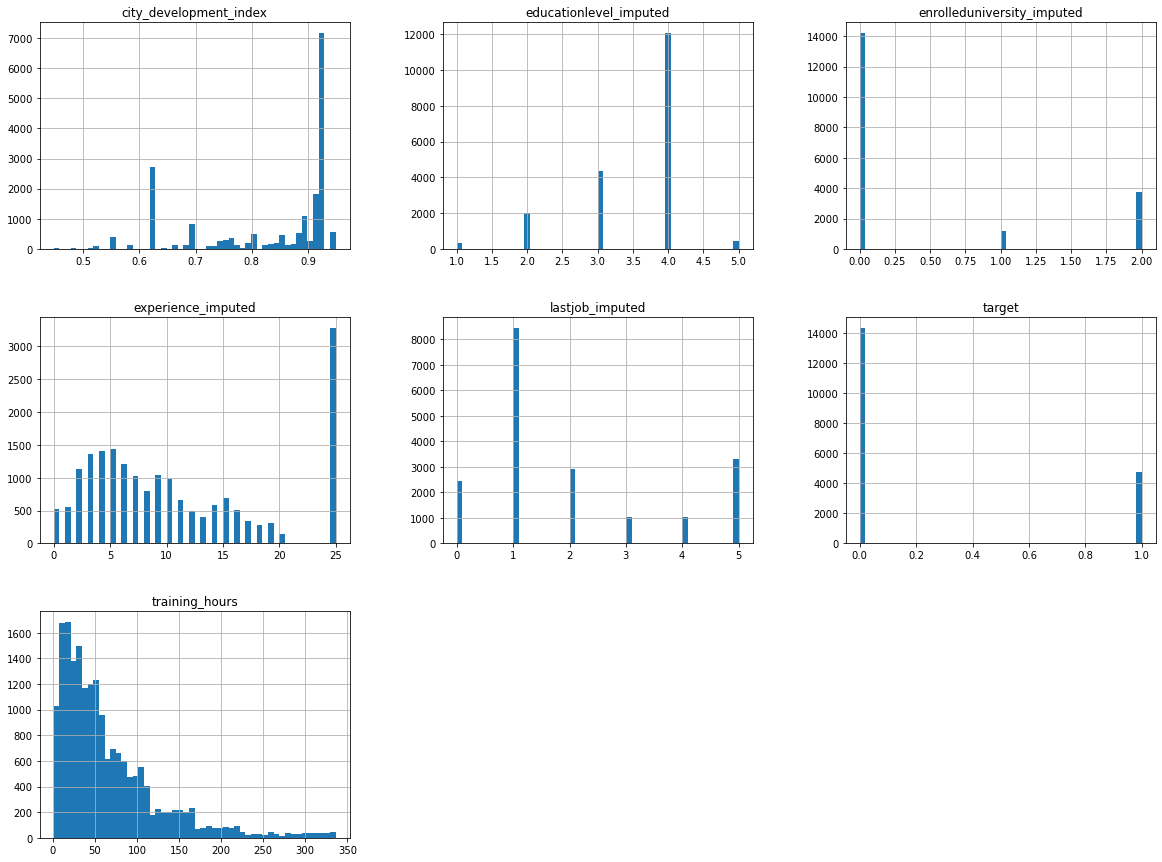

In [96]:
hiredata.hist(bins=50, figsize=(20,15)) #right skewed data for training hours
plt.show()

In [97]:
hiredata["relativeTraining"]= pd.cut(hiredata["training_hours"],
                               bins=[0., 20, 40, 60,80, np.inf],
                               labels=['Minimal', 'Some', 'Average','Above Average','Extremely'])

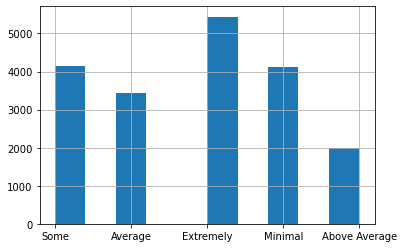

In [98]:
hiredata["relativeTraining"].hist() #force normal distribution 
plt.show()

In [99]:
hiredata['relativeTraining'].value_counts()

Extremely        5440
Some             4156
Minimal          4127
Average          3439
Above Average    1996
Name: relativeTraining, dtype: int64

In [100]:
corr_matrix = hiredata.corr()
corr_matrix["target"].sort_values(ascending=False)

target                        1.000000
enrolleduniversity_imputed    0.149539
educationlevel_imputed        0.067412
training_hours               -0.021577
lastjob_imputed              -0.084607
experience_imputed           -0.169640
city_development_index       -0.341602
Name: target, dtype: float64

In [101]:
hiredata.head()

,city,city_development_index,relevent_experience,major_discipline,training_hours,target,experience_imputed,lastjob_imputed,educationlevel_imputed,enrolleduniversity_imputed,relativeTraining
0,city_103,0.920,Has relevent experience,STEM,36,1,25.0,1.0,4.0,0.0,Some
1,city_40,0.776,No relevent experience,STEM,47,0,15.0,5.0,4.0,0.0,Average
2,city_21,0.624,No relevent experience,STEM,83,0,5.0,0.0,4.0,2.0,Extremely
3,city_115,0.789,No relevent experience,Business Degree,52,1,0.0,0.0,4.0,0.0,Average
4,city_162,0.767,Has relevent experience,STEM,8,0,25.0,4.0,3.0,0.0,Minimal


In [102]:
predictions.head()

,city,city_development_index,relevent_experience,major_discipline,training_hours,experience_imputed,lastjob_imputed,educationlevel_imputed,enrolleduniversity_imputed
0,city_21,0.624,No relevent experience,STEM,18,0.0,0.0,4.0,2.0
1,city_64,0.666,No relevent experience,Humanities,23,25.0,5.0,4.0,1.0
2,city_159,0.843,Has relevent experience,STEM,68,11.0,1.0,3.0,0.0


# Create Test and Training Sets

In [103]:
splitobj = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
for train_index, test_index in splitobj.split(hiredata, hiredata['relativeTraining']):
    train_set = hiredata.iloc[train_index]
    test_set = hiredata.iloc[test_index]

    
#do i have to stratify the predictions data?

In [104]:
print("Data set size: {:,}\nTraining set size: {:,} \nTest set size (20%): {:,}".format(
    len(hiredata),len(train_set),len(test_set)))

Data set size: 19,158
Training set size: 15,326 
Test set size (20%): 3,832


In [105]:
pd.DataFrame( { "Overall": hiredata["relativeTraining"].value_counts() / len(hiredata), 
               "Stratified": test_set["relativeTraining"].value_counts() / len(test_set) })

,Overall,Stratified
Extremely,0.283954,0.283925
Some,0.216933,0.216858
Minimal,0.215419,0.215553
Average,0.179507,0.179541
Above Average,0.104186,0.104123


In [106]:
train_set.drop("relativeTraining", axis=1, inplace=True)
test_set.drop("relativeTraining", axis=1, inplace=True)

C:\Users\ocmkd\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [107]:
#create a copy of the startified training data set to explore
train_copy= train_set.copy()

In [108]:
train_copy.head()

,city,city_development_index,relevent_experience,major_discipline,training_hours,target,experience_imputed,lastjob_imputed,educationlevel_imputed,enrolleduniversity_imputed
17715,city_21,0.624,Has relevent experience,STEM,74,1,4.0,1.0,4.0,0.0
10608,city_50,0.896,Has relevent experience,STEM,67,0,25.0,4.0,4.0,0.0
13639,city_103,0.920,Has relevent experience,STEM,6,1,14.0,3.0,4.0,0.0
18863,city_103,0.920,Has relevent experience,Humanities,13,1,19.0,1.0,4.0,0.0
11510,city_21,0.624,Has relevent experience,STEM,77,1,12.0,5.0,4.0,2.0


In [109]:
train_copy.shape

(15326, 10)

# prepare the data

In [110]:
#list the keys of the dataset
train_copy.keys()

#DESCR will describe the data, 'data' is the data itself

Index(['city', 'city_development_index', 'relevent_experience',
       'major_discipline', 'training_hours', 'target', 'experience_imputed',
       'lastjob_imputed', 'educationlevel_imputed',
       'enrolleduniversity_imputed'],
      dtype='object')

In [111]:
# assign x and y within the training set
x_train_pre = train_copy.drop("target",axis=1) #X value
y_train = train_copy["target"].copy() #Y value

In [112]:
# assign x and y within the test set
x_test_pre = test_set.drop("target",axis=1) #X value
y_test = test_set["target"].copy() #Y value

In [113]:
#shape of the training dataset; 14 features
x_train_pre.shape, y_train.shape, x_test_pre.shape, y_test.shape

((15326, 9), (15326,), (3832, 9), (3832,))

# Encode and Scale

In [114]:
#define variables needed to seperate numeric attributes from categorical attributes; !fix education level manually
ord_attribs = ['relevent_experience']
hot_attribs=['city','major_discipline']
num_attribs = list(x_train_pre.drop(ord_attribs+hot_attribs,axis=1) )

#list the numeric attributes
num_attribs

['city_development_index',
 'training_hours',
 'experience_imputed',
 'lastjob_imputed',
 'educationlevel_imputed',
 'enrolleduniversity_imputed']

In [116]:
#define pipeline for numeric attributes (this code is just a definition)
#each numeric attribute will be imputated using the Median strategy
#each numeric attribute will be scaled 
# each of numeric columns, run each through imputer and fill any empty values w median
#standard scalar standardizes through each numeric column
num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")),
 ('std_scaler', StandardScaler()),   
])

#define transformation pipeline for both numeric and category attributes in the dataframe
#numeric attributed will be processed by the num_pipeline defined above
#the category ocean proximity will be transformed using the One Hot Encoder method

full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('ord', OrdinalEncoder(), ord_attribs),
    ('hot', OneHotEncoder(), hot_attribs)
])

In [118]:
#take the training data set and create an array of prepared data
#transform data into matrix, figuring out scalers and encoders should be
x_train = full_pipeline.fit_transform(x_train_pre)
x_train.shape

(15326, 133)

In [45]:
# only transform, do not fit test data
x_test = full_pipeline.transform(x_test_pre)
x_test.shape

(3832, 133)

In [46]:
data_pred=full_pipeline.transform(predictions)
data_pred.shape

(3, 133)

In [47]:
#create Y values for our binary classifier 
#since we are going to decide if target or not, set y_train to 1 if indeed it is a 1 and zero otherwise; 
# use boolean
y_train_target = (y_train == 1)

#do the same thing to our test data set
y_test_target = (y_test == 1)

In [48]:
y_train_target[:15]

17715     True
10608    False
13639     True
18863     True
11510     True
17912    False
13681     True
5780     False
12337     True
407      False
11328    False
3941     False
7534      True
14306    False
8947     False
Name: target, dtype: bool

# SGD Classifier

In [49]:
#create the classification model
sgd_clf = SGDClassifier(random_state=42)

#fit the model using the training data set
sgd_clf.fit(x_train, y_train)

SGDClassifier(random_state=42)

In [50]:
#see how well the model peforms across a variety of cross sections; may want to increase to 5 or ten cv
score = cross_val_score(sgd_clf, x_train, y_train, cv=5, scoring="accuracy")
np.mean(score)

0.779720515169799

In [51]:
#get predictions aross 3 different folds using the default method (prediction scores)
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=5)

In [52]:
#display the confusion matrix and classification report
confusion_matrix(y_train, y_train_pred)

array([[10375,  1129],
       [ 2247,  1575]], dtype=int64)

In [53]:
classification_report(y_train,y_train_pred) #precision=0.58; recall=0.48; i think we prefer higher recall here, would rather have false positives than 

'              precision    recall  f1-score   support\n\n           0       0.82      0.90      0.86     11504\n           1       0.58      0.41      0.48      3822\n\n    accuracy                           0.78     15326\n   macro avg       0.70      0.66      0.67     15326\nweighted avg       0.76      0.78      0.77     15326\n'

In [72]:
#calculate measures
print("Precision Score: {:.2f}".format( precision_score(y_train, y_train_pred) ) )
print("   Recall Score: {:.2f}".format( recall_score(y_train, y_train_pred) ) )
print("       F1 Score: {:.2f}".format( f1_score(y_train, y_train_pred) ) )

Precision Score: 0.50
   Recall Score: 0.35
       F1 Score: 0.41


In [55]:
#see how well the model performs on the test data set
y_pred = sgd_clf.predict(x_test)
accuracy_score(y_pred, y_test)

0.7789665970772442

In [56]:
#calculate measures
print("Precision Score: {:.2f}".format( precision_score(y_pred, y_test) ) )
print("   Recall Score: {:.2f}".format( recall_score(y_pred, y_test) ) )
print("       F1 Score: {:.2f}".format( f1_score(y_pred, y_test) ) )

Precision Score: 0.39
   Recall Score: 0.58
       F1 Score: 0.47


In [57]:
data_pred_sgd=sgd_clf.predict(data_pred) #how to predict using model?

In [58]:
for x in range(3):
    if data_pred_sgd[x]==1:
        print("Person {} is a target".format(x))
    else: 
        print("Person {} is not a target".format(x))

Person 0 is a target
Person 1 is not a target
Person 2 is not a target


# Random Forest

In [59]:
#create the classification model
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

#fit the model using the training data set
forest_clf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [60]:
#see how well the model peforms across a variety of cross sections
score = cross_val_score(forest_clf, x_train, y_train, cv=5, scoring="accuracy")
np.mean(score)

0.7518594190452779

In [61]:
#get predictions aross 3 different folds using the default method (prediction scores)
y_train_pred = cross_val_predict(forest_clf, x_train, y_train, cv=5)

In [62]:
#display the confusion matrix; do the same w test?
confusion_matrix(y_train, y_train_pred)

array([[10185,  1319],
       [ 2484,  1338]], dtype=int64)

In [63]:
#calculate measures
print("Precision Score: {:.2f}".format( precision_score(y_train, y_train_pred) ) )
print("   Recall Score: {:.2f}".format( recall_score(y_train, y_train_pred) ) )
print("       F1 Score: {:.2f}".format( f1_score(y_train, y_train_pred) ) )

Precision Score: 0.50
   Recall Score: 0.35
       F1 Score: 0.41


In [64]:
#see how well the model performs on the test data set
y_pred = forest_clf.predict(x_test)
accuracy_score(y_pred, y_test)

0.7468684759916493

In [65]:
#calculate measures
print("Precision Score: {:.2f}".format( precision_score(y_pred, y_test) ) )
print("   Recall Score: {:.2f}".format( recall_score(y_pred, y_test) ) )
print("       F1 Score: {:.2f}".format( f1_score(y_pred, y_test) ) )

Precision Score: 0.33
   Recall Score: 0.49
       F1 Score: 0.39


In [66]:
#create a dataframe that has the feature importance
feature_importance=pd.DataFrame({
    'RandomForest':forest_clf.feature_importances_,
})

#sort the features
feature_importance.sort_values(by='RandomForest',ascending=False,inplace=True)
feature_importance

,RandomForest
1,0.363628
2,0.171695
0,0.097687
3,0.075124
68,0.046654
...,...
112,0.000068
115,0.000048
31,0.000039
66,0.000029


In [67]:
fi = feature_importance[:10]
fi

,RandomForest
1,0.363628
2,0.171695
0,0.097687
3,0.075124
68,0.046654
5,0.032694
4,0.031504
6,0.024066
132,0.009168
12,0.007319


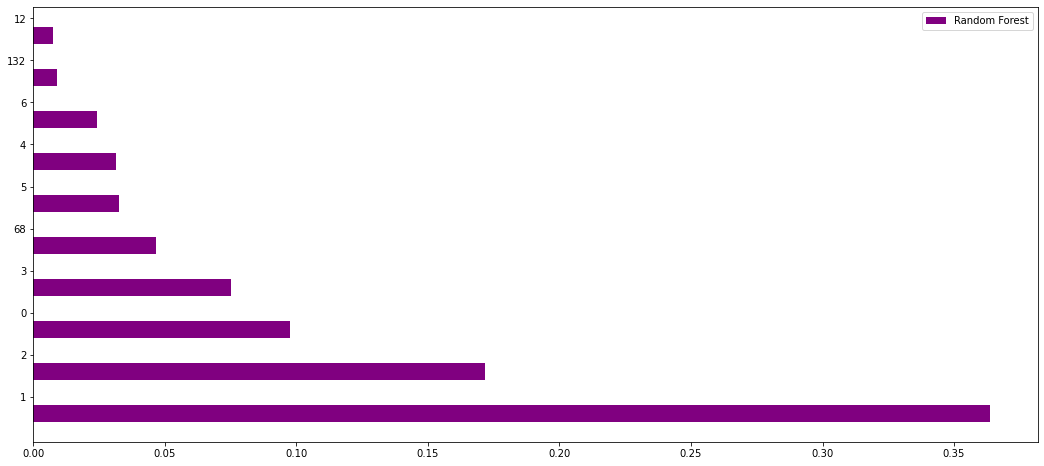

In [68]:
#graph the top features
index = np.arange(len(fi))
fig, ax = plt.subplots(figsize=(18,8))
rfc_feature=ax.barh(index,fi['RandomForest'],0.4,color='purple',label='Random Forest')
#dt_feature=ax.barh(index+0.4,fi['DecisionTree'],0.4,color='lightgreen',label='Decision Tree')
ax.set(yticks=index+0.4,yticklabels=fi.index)

ax.legend()
plt.show()

In [69]:
data_pred_forest=forest_clf.predict(data_pred)

In [70]:
for x in range(3):
    if data_pred_forest[x]==1:
        print("Person {} is a target".format(x))
    else: 
        print("Person {} is not a taregt".format(x))

Person 0 is a target
Person 1 is not a taregt
Person 2 is not a taregt
